In [2]:
# We will first import all the necessary libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

In [3]:
# Next we download the training data and test data as a dataframe and store it in df and df_test respectively.
df=pd.read_csv('/Users/shidhesh/Downloads/house-prices-advanced-regression-techniques/train.csv')
df_test=pd.read_csv('/Users/shidhesh/Downloads/house-prices-advanced-regression-techniques/test.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


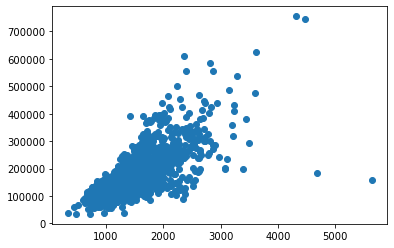

In [4]:
# After analysing all the columns, notice that GrLivArea column have a more prominent linear relation to SalePrice.
plt.scatter(df['GrLivArea'], df['SalePrice'])

In [5]:
# We get rid of outlier points
df=df.drop(df[(df['GrLivArea']>=4000) & (df['SalePrice']<=200000)].index)

In [6]:
# Store number of training and testing data instances.
df_train_in=df.shape[0]
df_test_in=df_test.shape[0]

# Remove SalePrice column and concatenate it to training data for pre-processing.
df_train=df.drop(columns='SalePrice')
all_data=pd.concat([df_train,df_test],axis='index').reset_index().drop(columns=['index','Id'])
all_data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2912,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2913,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2914,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
2915,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [7]:
# Now we will distribute the columns depending on whether the data is 
# categorical (pure_cat_col) or numerical (pure_num_col).
# There are few categorical data that can be easily assigned numerical values. For ex. Ex-4, Gd-3, Av-2, Po-1, NA-0
# We call such columns cat_to_num_col.
# Finally we also add year_col collecting columns describing year data.
# Goal is to preprocess these columns seperately.
pure_num_col = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
                      '1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF',
                      'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal']
pure_cat_col = ['MSZoning','Alley','Street','LotShape','LandContour', 'LotConfig', 'LandSlope', 'Neighborhood',
                     'Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st',
                      'Exterior2nd', 'MasVnrType','Foundation','Heating','CentralAir','Electrical','GarageType',
                     'MiscFeature','SaleType','SaleCondition']
cat_to_num_col = ['OverallQual','OverallCond','ExterQual', 'ExterCond','BsmtQual','BsmtCond','BsmtExposure',
                        'BsmtFinType1','BsmtFinType2','HeatingQC','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
                       'BedroomAbvGr','KitchenAbvGr','KitchenQual','TotRmsAbvGrd','Functional','Fireplaces',
                       'FireplaceQu','GarageFinish','GarageCars','GarageQual','GarageCond','PavedDrive','PoolQC',
                       'Fence']
year_col = ['YearBuilt','YearRemodAdd','GarageYrBlt']

In [12]:
# Many columns have NaN as their values. We fill these values based on type of column data.
# Define a function.
def fillna (df):
    num=df[pure_num_col].copy()
    cat=df[pure_cat_col].copy()
    cat_to_num=df[cat_to_num_col].copy()
    year=df[year_col].copy()
    
    # For numerical columns we replace NaN by 0.
    num.fillna(0.0,inplace=True)
    
    # For cat_to_num column we replace all NaN by 'Na' and then study columns individually to replace them by 
    # appropriate values.
    cat_to_num.fillna('NA',inplace=True)
    cat_to_num['BsmtHalfBath'].replace('NA',0, inplace=True)
    cat_to_num['BsmtFullBath'].replace('NA',0, inplace=True)
    cat_to_num['Functional'].replace('NA','Typ', inplace=True)
    cat_to_num['GarageCars'].replace('NA',0, inplace=True)
    
    # Replace all the NaN in year columns by minimum of year built. Later they will be binned in 0 bin.
    year.fillna(year['YearBuilt'].min(),inplace=True)
    # One instance of data has year 2207 as typo. We guess it to be 2007 and rectify it.
    year['GarageYrBlt'].replace(2207.0,2007,inplace=True)
    en_df=pd.concat([num,cat,cat_to_num,year],axis=1)
    return en_df
# Notice here that we did not change categorical data. Such data will be taken care during encoding stage.

In [9]:
# Encoding Prep
# Defining categorical order for Ordinal Encoder. We arrange the cat_to_num from least desirable rating to most 
# desirable rating. This will encode higher values to desirable qualities and lower values to less desirable 
# qualities.

l1=np.linspace(0,15,16)
l2=['NA','Po','Fa','TA','Gd','Ex']
l3=['NA','No','Mn','Av','Gd']
l4=['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ']
l5=['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ']
l6=['NA','Unf','RFn','Fin']
l7=['N','P','Y']
l8=['NA','MnWw','GdWo','MnPrv','GdPrv']

# A function to bin the years in categories
# Define the bin and assign numerical values to them using pd.cut.

def YearTransformer(temp):
    for col in year_col:
        temp[col]=pd.cut(temp[col],
                     bins=[0,1900,1920,1940,1950,1960,1970,1980,1990,2000,2010,2020,2030],
                     labels=[0,1,2,3,4,5,6,7,8,9,10,11])
    return temp[year_col]

# Convert this function into an encoder to use in column transformer.

YearTransformer=FunctionTransformer(YearTransformer)

In [10]:
#Define a column transformer which will deal with each column type with appropriate encoder.

column_tran=ColumnTransformer(transformers=
                             [('num',MinMaxScaler(),pure_num_col),
                             ('cat',OneHotEncoder(handle_unknown='ignore'),pure_cat_col),
                             ('cat_to_num',OrdinalEncoder(categories=[l1,l1,l2,l2,l2,l2,l3,l4,l4,l2,l1,l1,l1,l1,l1,l1,l2,l1,l5,l1,l2,l6,l1,l2,l2,l7,l2,l8]),cat_to_num_col),
                             ('year',YearTransformer,year_col)]
                             ) 

In [13]:
# First we replace all the NaN.
all_data_1=fillna(all_data)

In [14]:
# Use our column transformer to pre-process and set it as a dataframe.
en_all_data=pd.DataFrame(column_tran.fit_transform(all_data_1))

In [15]:
# Seperate out the encoded training data
X=en_all_data[:df_train_in]
X.shape

(1458, 231)

In [16]:
# Seperate out the encoded test data
X_test=en_all_data[df_train_in:]
X_test.shape

(1459, 231)

In [17]:
# Define a function which takes the training data and classifier to be used
# This performs a 5-fold split and evaluate rmse score.
def scorefor(X, y, classifier):
    k=5
    kfold = KFold(n_splits=k)
    rmse_score=[]
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]
        classifier.fit(X_train,y_train.values.ravel())
        y_hat=classifier.predict(X_test)
        y_hat=y_hat.reshape((y_test.size,1))
        score=np.sqrt(np.mean((y_hat-y_test)**2))
        rmse_score.append(score)
    print('RMSE is', sum(rmse_score)/k)

In [18]:
y=np.log(df['SalePrice'])
y=pd.DataFrame(y)

In [19]:
# State Vector Machine
State_Vector_Machine=SVR(kernel='linear')
scorefor(X,y,State_Vector_Machine)

RMSE is SalePrice    0.122212
dtype: float64


In [20]:
# Simple Linear Regression
reg = LinearRegression()
scorefor(X,y,reg)

RMSE is SalePrice    3.008269e+08
dtype: float64


In [21]:
# Gradient Boosting Regressor
Gradient_Boosting = GradientBoostingRegressor(
    max_depth=3,
    subsample=0.7,
    max_features=0.75,
    n_iter_no_change=1000,
    validation_fraction=0.06,
    tol=0.00006,
    random_state=1)
scorefor(X,y,Gradient_Boosting)

RMSE is SalePrice    0.120415
dtype: float64


In [22]:
# Lasso Regression
Lasso1 = Lasso(alpha=0.0025)
scorefor(X,y,Lasso1)

RMSE is SalePrice    0.136871
dtype: float64


In [23]:
# Stack and combine SVM, Gradient boosting, and Lasso classifier
from sklearn.ensemble import StackingRegressor

In [24]:
#Stacking

level_0= list()
level_0.append(('svm',State_Vector_Machine))
level_0.append(('GrBoost', Gradient_Boosting))
level_0.append(('Lss',Lasso1))

level_1=LinearRegression()

model=StackingRegressor(estimators=level_0, final_estimator=level_1,cv=5)

In [25]:
scorefor(X,y,model)

RMSE is SalePrice    0.11246
dtype: float64


In [26]:
# As the score for stacked model is better than individual classifier, we predict the data using this model.
y_test_hat=np.exp(model.predict(X_test))

In [27]:
# Create a dataframe to be submitted.
subm=pd.DataFrame()
subm['Id'] = df_test['Id']
subm['SalePrice'] = y_test_hat

In [28]:
# Convert data to csv and save in approprote dir.
subm.to_csv('/Users/shidhesh/Downloads/house-prices-advanced-regression-techniques/submission.csv', index=False)

# When submitted to Kaggle this provides 0.13 rmse for test data.